# Identifying handwritten digits with a multi-layer neural network

This project consists of a classic deep learning exercise which is the label handwritten digits from 0 to 9. We will also compare the results with the simpler K-Nearest Neighbors algorithm. The dataset used here is loaded directly from sklearn, but is originally hosted in [UCI's machine learning repository](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

data = load_digits()

# Each row conatins the 8x8=64 pixels for each image
data_features = pd.DataFrame(data['data'], columns=['pixel_'+str(x) for x in range(64)])
# The target identifies the number
data_target = pd.DataFrame(data['target'], columns=['target'])
# Merge both into a single dataframe
df = pd.concat([data_features, data_target], axis=1)
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


Each row contains the 8x8=64 pixels of an image. The target column indicates what number the image represents. Here's what the images look like:

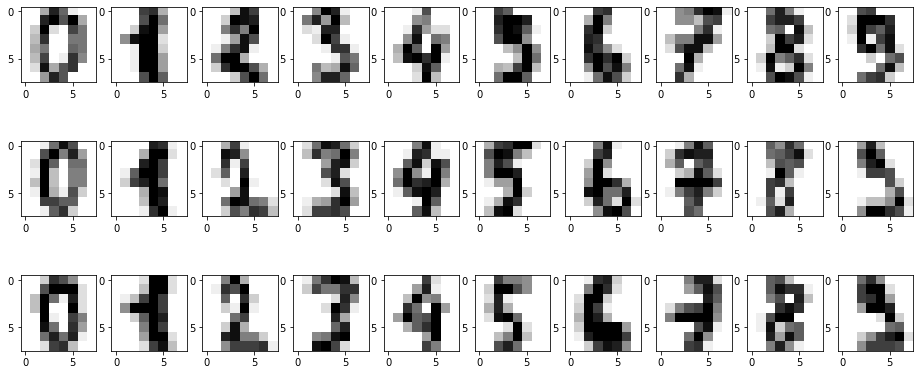

In [161]:
fig, axes = plt.subplots(3,10, figsize=(16,7))

for ii in range(10):
    for jj in range(3):
        axes[jj,ii].imshow(data['images'][ii + 10*jj], cmap='gray_r')

And here's a generic function to train and test the results using K-folds cross validation, using any model from the sklearn library.

In [163]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def train_and_crossvalidate(df, model, Nfolds=5):
    # Build KFold object which splits the data into train and test
    kf = KFold(n_splits=Nfolds, random_state=1)
    # pixels contains all columns used for training
    pixels = [x for x in df.columns if x.startswith('pixel_')]
    
    # Calculate accuracy score for each fold
    accuracies = []
    for train_index, test_index in kf.split(df):
        # Assign train and test datasets
        df_train = df.loc[train_index]
        df_test = df.loc[test_index]
        # Fit according to chosen model
        model.fit(df_train[pixels], df_train['target'])
        # Make predictions according to chosen model
        predictions = model.predict(df_test[features])
        # See how predictions compare to actual labels (the target colum)
        accuracies.append(accuracy_score(df_test['target'], predictions))

    # Return the averaged result    
    return np.mean(accuracies)

# K-nearest neighbors

Before dwelving into deep learning, let's have a look at the results that a simple k-nearest neighbors classifier would yield.

In [164]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
train_and_crossvalidate(df, knn)

0.9643933766635715

We get an accuracy of 96.4% on the first try! This is already not so bad. Let's explore the hyperparameter space a little bit a vary the number of nearest neighbors.

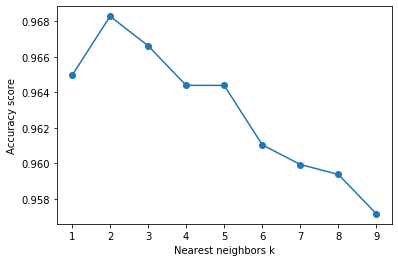

In [179]:
k_list = list(range(1,10))
accuracies = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc = train_and_crossvalidate(df, knn)
    accuracies.append(acc)
    
plt.figure()
plt.plot(k_list, accuracies, '-o')
plt.xlabel('Nearest neighbors k')
plt.ylabel('Accuracy score')
plt.show()

Looks like the optimal number of neighbors is 2, with an accuracy score of 96.8%.

# Multi-layer neural network

The downsides of using K-Nearest Neighbors is an expenditure of computer resources, because the calculations are applied for every test row. Let's explore the accuracy of a simple deep learning model. We will begin with a single layer and test for different sizes.

C:\Users\laurent\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


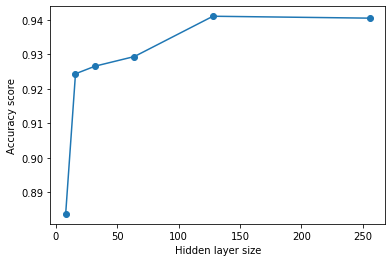

In [175]:
from sklearn.neural_network import MLPClassifier

layer_size_list = [8, 16, 32, 64, 128, 256] 
accuracies = []
for layer_size in layer_size_list:
    mlp = MLPClassifier(hidden_layer_sizes=(layer_size,), max_iter=1000, random_state=1)
    acc = train_and_crossvalidate(df, mlp)
    accuracies.append(acc)
    
plt.figure()
plt.plot(layer_size_list, accuracies, '-o')
plt.xlabel('Hidden layer size')
plt.ylabel('Accuracy score')
plt.show()

As expected from the litterature, increasing the size of the hidden layer improved the accuracy of the model. The accuracy plateaus at ~128 layers.

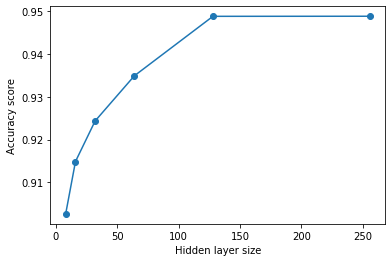

In [173]:
layer_size_list = [8, 16, 32, 64, 128, 256] 
accuracies = []
for layer_size in layer_size_list:
    mlp = MLPClassifier(hidden_layer_sizes=(layer_size, layer_size), max_iter=1000, random_state=1)
    acc = train_and_crossvalidate(df, mlp)
    accuracies.append(acc)

plt.figure()
plt.plot(layer_size_list, accuracies, '-o')
plt.xlabel('Hidden layer size')
plt.ylabel('Accuracy score')
plt.show()

Adding a second layer improved the accuracy, with similar dependency on size. Let's now fix the size of a layer and observe the effect of adding multiple layers.

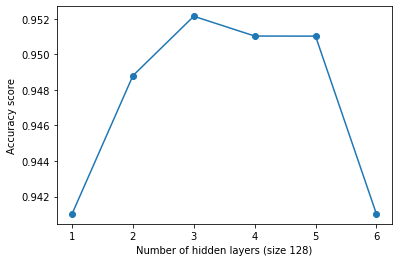

In [177]:
n_layers_list = list(range(1,7)) 
accuracies = []
for n_layers in n_layers_list:
    mlp = MLPClassifier(hidden_layer_sizes=(128,)*n_layers, max_iter=1000, random_state=1)
    acc = train_and_crossvalidate(df, mlp)
    accuracies.append(acc)
    
plt.figure()
plt.plot(n_layers_list, accuracies, '-o')
plt.xlabel('Number of hidden layers (size 128)')
plt.ylabel('Accuracy score')
plt.show()

As expected, adding layers improves accuracy, up to a certain point where the model could be overfitting. Let's use 3 layers of size 128 for our final result.

In [178]:
accuracies[2]

0.9521479418136799

Thus, the accuracy of our multi-layer neural network is 95.21%. Follows an simple test for single values, where the model is trained on all data excepted for the requested test. If anything, the accuracy should be higher here because we have more training data.

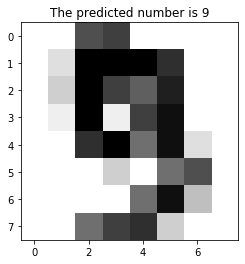

In [223]:
TEST_INDEX=9
plt.imshow(data['images'][TEST_INDEX], cmap='gray_r')

pixels = [x for x in df.columns if x.startswith('pixel_')]

df_train = df.loc[df.index != TEST_INDEX]
ar_test = df.loc[TEST_INDEX, pixels].values.reshape(1, -1)

mlp = MLPClassifier(hidden_layer_sizes=(128,)*3, max_iter=1000, random_state=1)
mlp.fit(df_train[pixels], df_train['target'])
prediction = mlp.predict(ar_test)

plt.title('The predicted number is {}'.format(prediction[0]))
plt.show()

# Conclusion

In this project, we implemented a classic multi-layer neural network to label handwritten digits from 0 to 9, and compared the results with a K-Nearest Neighbors algorithm. The handwritten digits used were 8x8 images taken from the sklearn library.

The final accuracies of the K-nearest neighbor and multi-layer neural network algorithms are 96.8% and 95.2%, respectively. Although the K-nearest neighboor model has a slight accuracy advantage, the deep learning models and more faster to test. It also seems like both models tend to overfit, which might be a consequence of the small number of observations in the data, and could be improved by playing with the alpha parameter in the MLP classifier.